# Tutorial 7: Multi-sample integration of spatial RNA-ATAC co-profiling mouse brain samples across different developmental stages

The [spatial RNA-ATAC co-profiling mouse brain datasets](https://www.nature.com/articles/s41592-023-01884-1), generated by MISAR-seq technique, include four samples from E11.0, E13.5, E15.5 and E18.5 stages and measure the spatial transcriptomic and ATAC-seq profiles simultaneously.

In [1]:
import warnings
import pandas as pd
import numpy as np
import scanpy as sc
import episcanpy.api as epi
from PRESENT import gene_sets_alignment, peak_sets_alignment, PRESENT_BC_function

warnings.filterwarnings("ignore")
sc.set_figure_params(dpi=80, figsize=(4,4), facecolor="white")

## Load paired SRT data

In [2]:
## Load spatial rna-seq data from multiple developmental stages
adata_rna_list = []
for stage in ["E11_0", "E13_5", "E15_5", "E18_5"]:
    cdata = sc.read_h5ad(f"Data/{stage}_expr.h5ad")
    cdata.obs["sample"] = stage
    adata_rna_list.append(cdata)

In [3]:
## feature sets unification
adata_rna_list = gene_sets_alignment(adata_rna_list)
adata_rna = adata_rna_list[0].concatenate(adata_rna_list[1:])
print(adata_rna)

AnnData object with n_obs × n_vars = 7118 × 32285
    obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRatio', 'Gex_nUMI', 'Gex_nGenes', 'Gex_MitoR

## Load paired spatial ATAC-seq data

In [4]:
## Load spatial ATAC-seq data from multiple developmental stages
adata_atac_list = []
for stage in ["E11_0", "E13_5", "E15_5", "E18_5"]:
    cdata = sc.read_h5ad(f"Data/{stage}_atac.h5ad")
    cdata.obs["sample"] = stage
    adata_atac_list.append(cdata)

In [5]:
## feature sets unification
adata_atac_list = peak_sets_alignment(adata_atac_list)
adata_atac = adata_atac_list[0].concatenate(adata_atac_list[1:])
print(adata_atac)

Peak merged
Peak filtered
Matrix merged
AnnData object with n_obs × n_vars = 7113 × 64537
    obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'Gex_RiboRati

## Run PRESENT model

In [6]:
adata = PRESENT_BC_function(
    spatial_key = "spatial", ## obsm key under which to load the spatial matrix of spots
    batch_key = "sample", ## obs key under which to load the batch indices of spots
    adata_atac = adata_atac, ## The ATAC raw fragment count matrix of spots in anndata.AnnData format
    peak_min_cells_fraction = 0.03, ## Minimum fraction of cells accessible required for a peak to pass filtering
    adata_rna = adata_rna, ## The ATAC raw fragment count matrix of spots in anndata.AnnData format
    gene_min_cells = 1, ## Minimum number of cells expressed required for a gene to pass filtering
    num_hvg = 3000, ## Number of highly variable genes to select for RNA data
    nclusters = adata_rna.obs["Annotation_for_Combined"].nunique(),
    device = "cuda" ## Device used for training: cuda or cpu
)
print(adata)

Loading data and parameters...
Input data has been loaded


First-stage trains basic model:  27%|▎| 27/100 [22:25<1:00:36, 49.82s/it, NLL_loss=0.782, BNN_loss=1.22, MSE_loss=0.335, IOA_loss=0.159, ES counter=20, ES pati


Early stop the first-stage training process


Second-stage trains BC model:  17%|▏| 17/100 [25:09<2:02:50, 88.80s/it, IBA_loss=1.04, IBP_loss=0.0589, DISC_loss=1.39, GEN_loss=-1.39, ES counter=10, ES patie


Early stop the second-stage training process
Succeed to find 16 clusters at resolution 0.984
AnnData object with n_obs × n_vars = 7113 × 50
    obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags',

## Visualization

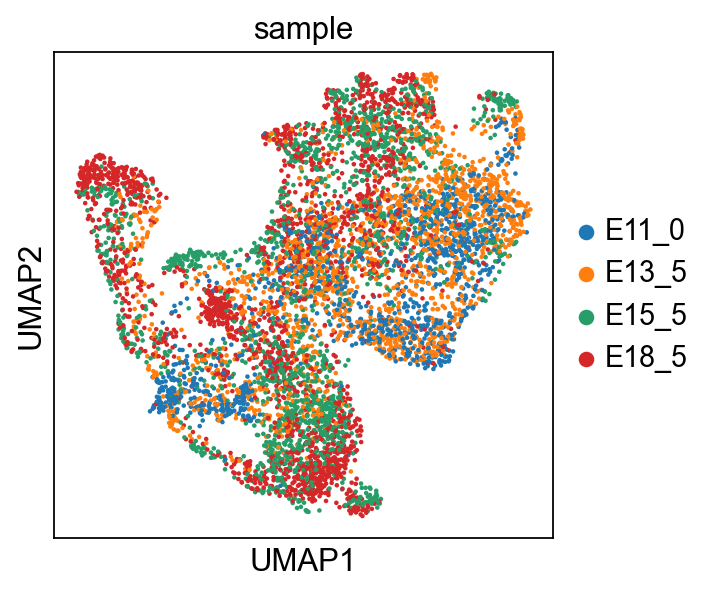

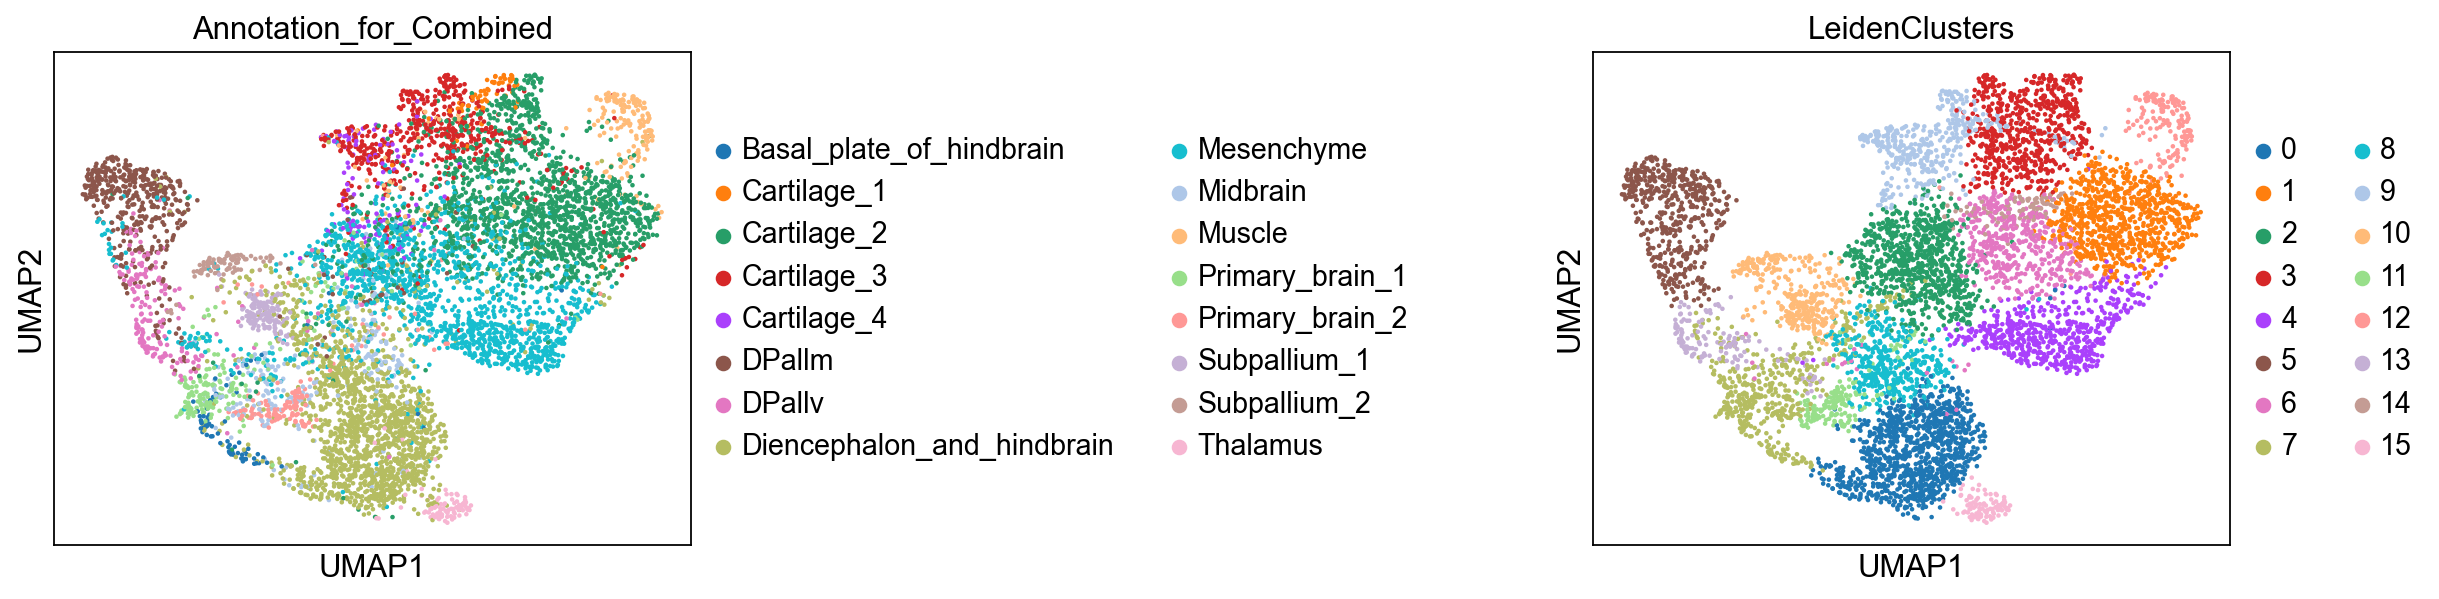

In [7]:
sc.pp.neighbors(adata, use_rep="embeddings")
sc.tl.umap(adata)
sc.pl.umap(adata, color="sample")
sc.pl.umap(adata, color=["Annotation_for_Combined", "LeidenClusters"], wspace=1.2)